In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report

#1. Observation the dataset

##Data preprocessing

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/AIL/spam_ham_dataset.csv")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [ ]:
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [ ]:
spam_harm_count = df['label_num'].value_counts()
spam_harm_count

0    3672
1    1499
Name: label_num, dtype: int64

In [ ]:
total = spam_harm_count.sum()

ratio_harm = (spam_harm_count[0]/total)*100
ratio_spam = (spam_harm_count[1]/total)*100

print("Ratio of harm:",ratio_harm)
print("Ratio of spam:",ratio_spam)

Ratio of harm: 71.01140978534133
Ratio of spam: 28.98859021465867


##Visualization the dataset

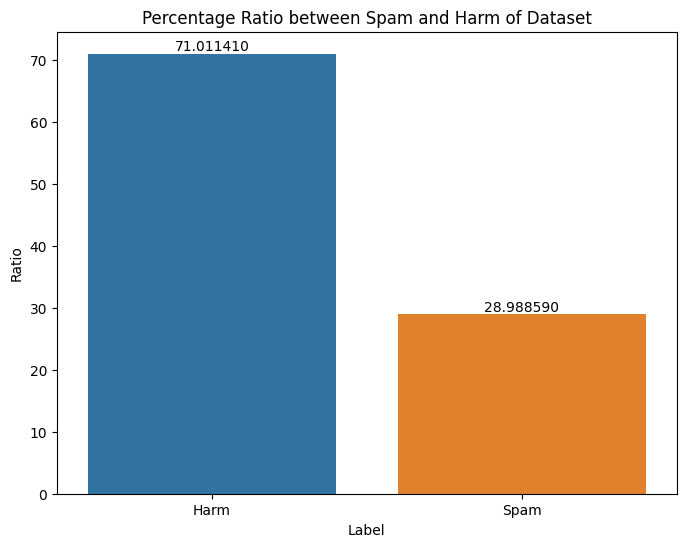

In [ ]:
data = {
    'Ratio': [ratio_harm, ratio_spam],
    'Label': ['Harm', 'Spam']
}
df_ratio_spam_harm = pd.DataFrame(data)

plt.figure(figsize=(8, 6))
sns.barplot(x='Label', y='Ratio', data=df_ratio_spam_harm)

for index, row in df_ratio_spam_harm.iterrows():
    plt.annotate(f'{row["Ratio"]:f}', (index, row["Ratio"]), ha='center', va='bottom')

plt.xlabel('Label')
plt.ylabel('Ratio')
plt.title('Percentage Ratio between Spam and Harm of Dataset')
plt.show()

##Splitting train, validation and test set

In [ ]:
X = df['text']
y = df['label_num']

In [ ]:
X_train, X_, y_train, y_ = train_test_split(X, y, train_size=0.8, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, random_state=0)

In [ ]:
# Initialization Text Vectorizer
vectorizer = TfidfVectorizer()

# Fit and transferring data to
X_train_vec = vectorizer.fit_transform(X_train)
X_val_vec = vectorizer.transform(X_val)
X_test_vec = vectorizer.transform(X_test)

In [ ]:
X_train_vec.shape

(4136, 43487)

In [ ]:
y_train.shape

(4136,)

#2. Creating a model by SVM

##Finding C and ɣ hyperparameters by the optimal algorithm GridSearchCV



In [ ]:
from sklearn.model_selection import GridSearchCV
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [ ]:
Cs_g = svc_param_selection(X_val_vec, y_val, 5)

In [ ]:
Cs_g['C'], Cs_g['gamma']

(10, 0.1)

##Model training

In [ ]:
model = svm.SVC(kernel='rbf', C=Cs_g['C'], gamma=Cs_g['gamma'])

In [ ]:
model.fit(X_train_vec, y_train)

SVC(C=10, gamma=0.1)

In [ ]:
# Label prediction for training data
y_train_pred = model.predict(X_train_vec)

# Label prediction for validation data
y_val_pred = model.predict(X_val_vec)

# Label prediction for testing data
y_test_pred = model.predict(X_test_vec)

#3. Model validation

In [ ]:
#Error metrics for skewed classes

with open('classification_report_train.txt', 'w') as file:
    file.write(classification_report(y_train, y_train_pred))

with open('classification_report_validation.txt', 'w') as file:
    file.write(classification_report(y_val, y_val_pred))

with open('classification_report_test.txt', 'w') as file:
    file.write(classification_report(y_test, y_test_pred))

In [ ]:
# Train error
train_error = 1 - accuracy_score(y_train, y_train_pred)

# Validation error
val_error = 1 - accuracy_score(y_val, y_val_pred)

# Test error
test_error = 1 - accuracy_score(y_test, y_test_pred)

In [ ]:
print("Train Error:", train_error)
print("Validation Error:", val_error)
print("Test Error:", test_error)

Train Error: 0.00024177949709869306
Validation Error: 0.023210831721469982
Test Error: 0.013513513513513487


> ***Save the model by pickle***




In [ ]:
with open('/content/drive/MyDrive/AIL/testing/model.pkl', 'wb') as file:
    pickle.dump((model, vectorizer), file)